# SARSA and Q-Learning Demo

In [34]:
# Import Necessary Libraries
import time
import json
import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.envs.toy_text.frozen_lake import MAPS

In [35]:
def dump_list_to_json(array, filename):
    with open(filename, 'w') as f:
        json.dump(array, f, indent=4)
    print(f"Array successfully saved to {filename}")

def load_list_from_json(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    print(f"Array successfully loaded from {filename}")
    return array

In [43]:
# Kasus-kasus yang dapat dipelajari
environments = ['CliffWalking-v0', 'FrozenLake-v1', 'Taxi-v3']

# Fungsi instance Reinforcement Learning
# Kelas dapat diinstansiasi dengan memasukkan beberapa parameter

class RLInstance():
    def __init__(self, 
                 alpha, 
                 gamma, 
                 epsilon,
                 epsilon_decay_rate=0,
                 is_slippery=False, 
                 environment='FrozenLake-v1',
                 size=4,
                 map_name=None,
                 render=False):
        self.alpha = alpha                              # Learning Rate / Laju pembelajaran
        self.gamma = gamma                              # Discount Factor
        self.epsilon = epsilon                          # Exploration Rate / Peluang agen melakukan eksplorasi
        self.epsilon_decay_rate = epsilon_decay_rate    # Decay rate of epsilon per episode / Penurunan epsilon per episode
        self.is_slippery = is_slippery                  # Apakah ada kemungkinan agen mengalami slip
        if not environment in environments:
            raise ValueError('Unrecognized Reinforcement Learning environment.')
        self.environment = environment
        self.size = size
        self.map_name = map_name
        self.render = render
        

    def print_experiment_details(self, episodes, train_mode):
        print(f'{"Training" if train_mode else "Testing"} on {self.environment} with {episodes} episodes')
        print(f'Slippery mode: {"On" if self.is_slippery else "Off"}')
        print()
        print('Initial Parameters:') 
        print(f'Alpha (Learning Rate)      : {self.alpha}')
        print(f'Gamma (Discount Factor)    : {self.gamma}')
        print(f'Epsilon (Exploration Rate) : {self.epsilon}')
        print(f'Epsilon decay rate         : {self.epsilon_decay_rate}')
        

    def env_init(self, learn_type, train_mode):
        if self.map_name is None:
            map_ = generate_random_map(self.size)
            print(f'Map size: {self.size}x{self.size}\n\n')
        else:
            map_ = None
            print(f'Map size: {self.map_name}\n\n')
    
        if not train_mode:
            json_dir = f'{self.environment}_{self.size}x{self.size}_map_{learn_type}.json' if self.environment=='FrozenLake-v1' else f'{self.environment}_map_{learn_type}.json'
            map_ = load_list_from_json(json_dir)

        render_mode = 'human' if self.render else None
        
        env = gym.make(self.environment, 
                       map_name=self.map_name, 
                       desc=map_, 
                       is_slippery=self.is_slippery, 
                       render_mode=render_mode) if self.environment == 'FrozenLake-v1' else gym.make(self.environment, render_mode=render_mode)

        if train_mode:
            q = np.zeros((env.observation_space.n, env.action_space.n))
        else:
            q_dir = f'{self.environment}_{self.size}x{self.size}_q_table_{learn_type}.json' if self.environment=='FrozenLake-v1' else f'{self.environment}_q_table_{learn_type}.json'
            q = np.array(load_list_from_json(q_dir))

        return env, q, map_


    def experiment_end(self, 
                       episodes, 
                       learn_type, 
                       map_, 
                       q, 
                       total_actions,
                       rewards_per_episode,
                       train_mode, 
                       start_time, 
                       end_time):
        if train_mode:
            sum_rewards = np.zeros(episodes)
            for t in range(episodes):
                sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
            plt.plot(sum_rewards)
            plt.savefig(f'{self.environment}_{self.size}x{self.size}_{learn_type}.png' if self.environment=='FrozenLake-v1' else f'{self.environment}_{learn_type}.png')
            
            # Kita save masing - masing q-table dan map ke file 
            if (self.map_name is None):
                dump_list_to_json(q.tolist(), f'{self.environment}_{self.size}x{self.size}_q_table_{learn_type}.json' if self.environment=='FrozenLake-v1' else f'{self.environment}_q_table_{learn_type}.json') 
                dump_list_to_json(map_, f'{self.environment}_{self.size}x{self.size}_map_{learn_type}.json' if self.environment=='FrozenLake-v1' else f'{self.environment}_map_{learn_type}.json')
            else:
                dump_list_to_json(q.tolist(), f'{self.environment}_{self.map_name}_q_table_{learn_type}.json' if self.environment=='FrozenLake-v1' else f'{self.environment}_q_table_{learn_type}.json')
                dump_list_to_json(MAPS[map_name], f'{self.environment}_{self.map_name}_map_{learn_type}.json' if self.environment=='FrozenLake-v1' else f'{self.environment}_map_{learn_type}.json')
    
            print("\n\n")
            print("Training completed.")
            print("Total episodes: ", episodes)
            print("Total time taken: ", end_time - start_time, " seconds\n\n")
    
            print("Final Parameters: \n")
            print("Final learning rate (alpha): ", self.alpha)
            print("Final epsilon: ", self.epsilon, "\n")
    
            print(f"Final Q-Table ({len(q)} states): \n")
            print(q)
        else :
            print("Total actions taken : ", total_actions)

    
    def run_q_learning(self, 
                       episodes, 
                       train_mode=True):

        train_mode = train_mode
        self.print_experiment_details(episodes, train_mode)
        env, q, map_ = self.env_init('Q-learning', train_mode)
        
        rewards_per_episode = np.zeros(episodes)
        total_actions = 0
    
        print('')
        start_time = time.time()
        
        for i in range(episodes):
            if i % 1000 == 0 and train_mode:
                print(f'Episode {i}/{episodes}')
    
            state = env.reset()[0]
            terminated = False
            truncated = False
    
            while not terminated and not truncated:
                if train_mode and np.random.rand() < self.epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(q[state, :])
    
                new_state, reward, terminated, truncated, _ = env.step(action)
    
                if train_mode:
                    q[state, action] += self.alpha * (reward + self.gamma * np.max(q[new_state, :]) - q[state, action])
                else:
                    total_actions += 1
                state = new_state
    
            self.epsilon = max(0.0001, self.epsilon - self.epsilon_decay_rate)
            if self.epsilon == 0:
                self.alpha = 0.0001
            if reward == 1:
                rewards_per_episode[i] = 1
    
        env.close()
        end_time = time.time()
        self.experiment_end(episodes, 'Q-learning', map_, q, total_actions, rewards_per_episode, train_mode, start_time, end_time)

    
    def run_SARSA(self, 
                  episodes, 
                  train_mode=True):

        train_mode = train_mode
        self.print_experiment_details(episodes, train_mode)
        env, q, map_ = self.env_init('SARSA', train_mode)
        
        rewards_per_episode = np.zeros(episodes)
        total_actions = 0
    
        print('')
        start_time = time.time()
        
        for i in range(episodes):
            if i % 1000 == 0 and train_mode:
                print(f'Episode {i}/{episodes}')
    
            state = env.reset()[0]
            terminated = False
            truncated = False

            if train_mode and np.random.rand() < self.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state, :])
    
            while not terminated and not truncated:
                new_state, reward, terminated, truncated, _ = env.step(action)
                
                if train_mode and np.random.rand() < self.epsilon:
                    next_action = env.action_space.sample()
                else:
                    next_action = np.argmax(q[new_state, :])
    
                if train_mode:
                    q[state, action] += self.alpha * (reward + self.gamma * q[new_state, next_action] - q[state, action])
                else:
                    total_actions += 1
                    
                state = new_state
                action = next_action
    
            self.epsilon = max(0.0001, self.epsilon - self.epsilon_decay_rate)
            if self.epsilon == 0:
                self.alpha = 0.0001
            if reward == 1:
                rewards_per_episode[i] = 1
    
        env.close()
        end_time = time.time()
        self.experiment_end(episodes, 'SARSA', map_, q, total_actions, rewards_per_episode, train_mode, start_time, end_time)
            

## SARSA

Training on FrozenLake-v1 with 20000 episodes
Slippery mode: Off

Initial Parameters:
Alpha (Learning Rate)      : 0.1
Gamma (Discount Factor)    : 0.9
Epsilon (Exploration Rate) : 1
Epsilon decay rate         : 0
Map size: 4x4



Episode 0/20000
Episode 1000/20000
Episode 2000/20000
Episode 3000/20000
Episode 4000/20000
Episode 5000/20000
Episode 6000/20000
Episode 7000/20000
Episode 8000/20000
Episode 9000/20000
Episode 10000/20000
Episode 11000/20000
Episode 12000/20000
Episode 13000/20000
Episode 14000/20000
Episode 15000/20000
Episode 16000/20000
Episode 17000/20000
Episode 18000/20000
Episode 19000/20000
Array successfully saved to FrozenLake-v1_4x4_q_table_SARSA.json
Array successfully saved to FrozenLake-v1_4x4_map_SARSA.json



Training completed.
Total episodes:  20000
Total time taken:  3.0235249996185303  seconds


Final Parameters: 

Final learning rate (alpha):  0.1
Final epsilon:  1 

Final Q-Table (16 states): 

[[0.01422329 0.03999167 0.         0.01560952]
 [0.       

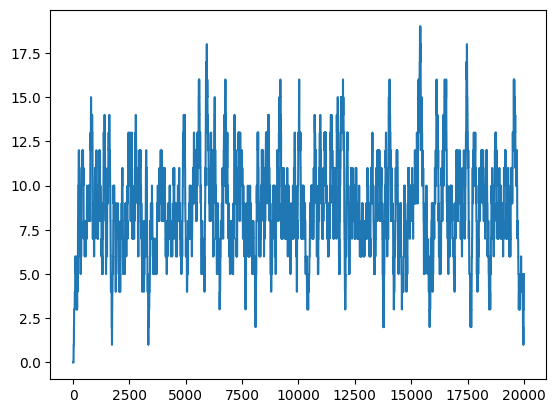

In [47]:
# Environment: Frozen Lake
sarsa = RLInstance(0.1, 0.9, 1)
sarsa.run_SARSA(20000)

Training on Taxi-v3 with 20000 episodes
Slippery mode: Off

Initial Parameters:
Alpha (Learning Rate)      : 0.3
Gamma (Discount Factor)    : 0.8
Epsilon (Exploration Rate) : 1
Epsilon decay rate         : 0
Map size: 4x4



Episode 0/20000
Episode 1000/20000
Episode 2000/20000
Episode 3000/20000
Episode 4000/20000
Episode 5000/20000
Episode 6000/20000
Episode 7000/20000
Episode 8000/20000
Episode 9000/20000
Episode 10000/20000
Episode 11000/20000
Episode 12000/20000
Episode 13000/20000
Episode 14000/20000
Episode 15000/20000
Episode 16000/20000
Episode 17000/20000
Episode 18000/20000
Episode 19000/20000
Array successfully saved to Taxi-v3_q_table_SARSA.json
Array successfully saved to Taxi-v3_map_SARSA.json



Training completed.
Total episodes:  20000
Total time taken:  69.3453962802887  seconds


Final Parameters: 

Final learning rate (alpha):  0.3
Final epsilon:  1 

Final Q-Table (500 states): 

[[  0.           0.           0.           0.           0.
    0.        ]
 [-16.8614

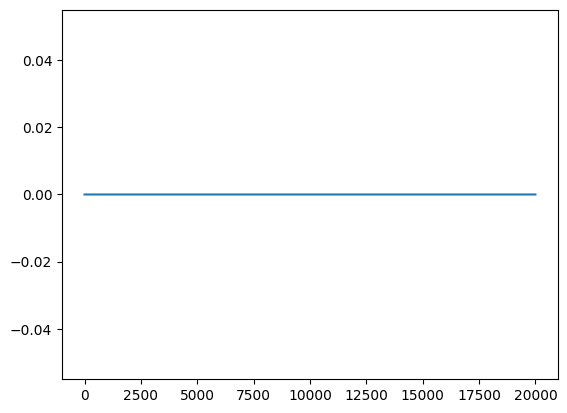

In [50]:
# Environment: Taxi
sarsa = RLInstance(0.3, 0.8, 1, environment='Taxi-v3')
sarsa.run_SARSA(20000)

## Q-Learning

Training on FrozenLake-v1 with 20000 episodes
Slippery mode: Off

Initial Parameters:
Alpha (Learning Rate)      : 0.1
Gamma (Discount Factor)    : 0.9
Epsilon (Exploration Rate) : 0.99
Epsilon decay rate         : 0
Map size: 4x4



Episode 0/20000
Episode 1000/20000
Episode 2000/20000
Episode 3000/20000
Episode 4000/20000
Episode 5000/20000
Episode 6000/20000
Episode 7000/20000
Episode 8000/20000
Episode 9000/20000
Episode 10000/20000
Episode 11000/20000
Episode 12000/20000
Episode 13000/20000
Episode 14000/20000
Episode 15000/20000
Episode 16000/20000
Episode 17000/20000
Episode 18000/20000
Episode 19000/20000
Array successfully saved to FrozenLake-v1_4x4_q_table_Q-learning.json
Array successfully saved to FrozenLake-v1_4x4_map_Q-learning.json



Training completed.
Total episodes:  20000
Total time taken:  3.9018754959106445  seconds


Final Parameters: 

Final learning rate (alpha):  0.1
Final epsilon:  0.99 

Final Q-Table (16 states): 

[[0.531441 0.59049  0.       0.531441]
 [0

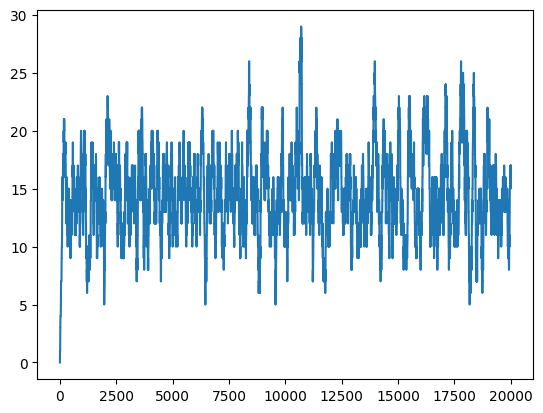

In [46]:
ql = RLInstance(0.1, 0.9, 0.99)
ql.run_q_learning(20000)

Training on Taxi-v3 with 20000 episodes
Slippery mode: Off

Initial Parameters:
Alpha (Learning Rate)      : 0.1
Gamma (Discount Factor)    : 0.9
Epsilon (Exploration Rate) : 1
Epsilon decay rate         : 0
Map size: 4x4



Episode 0/20000
Episode 1000/20000
Episode 2000/20000
Episode 3000/20000
Episode 4000/20000
Episode 5000/20000
Episode 6000/20000
Episode 7000/20000
Episode 8000/20000
Episode 9000/20000
Episode 10000/20000
Episode 11000/20000
Episode 12000/20000
Episode 13000/20000
Episode 14000/20000
Episode 15000/20000
Episode 16000/20000
Episode 17000/20000
Episode 18000/20000
Episode 19000/20000
Array successfully saved to Taxi-v3_q_table_Q-learning.json
Array successfully saved to Taxi-v3_map_Q-learning.json



Training completed.
Total episodes:  20000
Total time taken:  90.05054664611816  seconds


Final Parameters: 

Final learning rate (alpha):  0.1
Final epsilon:  1 

Final Q-Table (500 states): 

[[ 0.          0.          0.          0.          0.          0.        ]

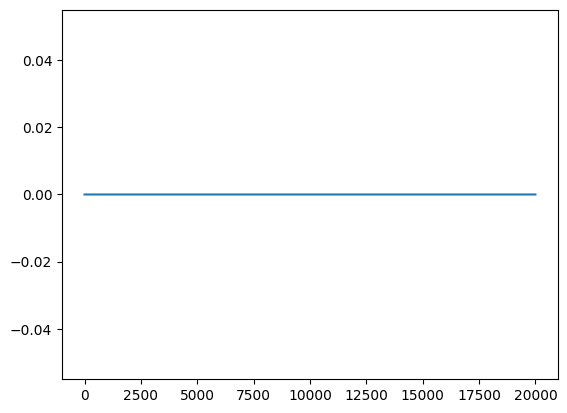

In [51]:
ql = RLInstance(0.1, 0.9, 1, environment='Taxi-v3')
ql.run_q_learning(20000)